In [2]:
## importing dataset from drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [53]:
IMAGE_PATH="/content/drive/MyDrive/NumberPlates/Images"

In [54]:
import pandas as pd
df=pd.read_csv("/content/drive/MyDrive/NumberPlates/NumberPlates.csv")
df.head()

,Image name,xmin,ymin,xmax,ymax
0,Cars0.png,226,125,419,173
1,Cars1.png,134,128,262,160
2,Cars2.png,229,176,270,193
3,Cars3.png,142,128,261,157
4,Cars4.png,156,82,503,253


In [55]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
import cv2
from keras.applications.vgg16 import VGG16

In [56]:
WIDTH=224
HEIGHT=224
CHANNEL=3

In [64]:

model=Sequential()

model.add(VGG16(weights="imagenet", include_top=False, input_shape=(HEIGHT, WIDTH, CHANNEL)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4))
model.layers[-6].trainable = False

model.compile(optimizer='adam', loss="mse")

In [65]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               3211392   
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 4)                 260       
                                                                 
Total params: 17,938,756
Trainable params: 3,224,068
N

In [66]:
### Training and validating model

train_datagen=image.ImageDataGenerator(rescale=1./255,zoom_range=0.1,validation_split=0.1)

train_generator = train_datagen.flow_from_dataframe(
    df,
    directory=IMAGE_PATH,
    x_col="Image name",
    y_col=["xmin", "ymin", "xmax", "ymax"],
    target_size=(WIDTH, HEIGHT),
    batch_size=32, 
    class_mode="raw",
    subset="training")

Found 297 validated image filenames.


In [67]:
validation_generator = train_datagen.flow_from_dataframe(
    df,
    directory=IMAGE_PATH,
    x_col="Image name",
    y_col=["xmin", "ymin", "xmax", "ymax"],
    target_size=(WIDTH, HEIGHT),
    batch_size=32, 
    class_mode="raw",
    subset="validation")

Found 33 validated image filenames.


In [68]:
STEP_SIZE_TRAIN = int(np.ceil(train_generator.n / train_generator.batch_size))
STEP_SIZE_VAL = int(np.ceil(validation_generator.n / validation_generator.batch_size))

print("Train step size and Batch size:", STEP_SIZE_TRAIN,train_generator.batch_size)
print("Validation step size:", STEP_SIZE_VAL)

train_generator.reset()
validation_generator.reset()

Train step size and Batch size: 10 32
Validation step size: 2


In [73]:
history = model.fit_generator(train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VAL,
    epochs=40)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/40
10/10 [==============================] - 12s 1s/step - loss: 40108.3047 - val_loss: 28143.8242
Epoch 2/40
10/10 [==============================] - 10s 972ms/step - loss: 16173.7422 - val_loss: 5222.4795
Epoch 3/40
10/10 [==============================] - 10s 961ms/step - loss: 6770.5654 - val_loss: 3452.8062
Epoch 4/40
10/10 [==============================] - 10s 962ms/step - loss: 4859.7363 - val_loss: 3981.2212
Epoch 5/40
10/10 [==============================] - 10s 957ms/step - loss: 4461.1641 - val_loss: 3149.0786
Epoch 6/40
10/10 [==============================] - 10s 949ms/step - loss: 4000.3228 - val_loss: 2808.3147
Epoch 7/40
10/10 [==============================] - 10s 1s/step - loss: 3766.8931 - val_loss: 2763.3184
Epoch 8/40
10/10 [==============================] - 10s 965ms/step - loss: 3412.1494 - val_loss: 2345.0693
Epoch 9/40
10/10 [==============================] - 10s 987ms/step - loss: 3157.8235 - val_loss: 2298.5479
Epoch 10/40
10/10 [=====================

In [74]:
model.evaluate(validation_generator, steps=STEP_SIZE_VAL)

2/2 [==============================] - 1s 48ms/step - loss: 614.5651


614.5650634765625

In [75]:
### save the model
model.save('/content/drive/MyDrive/NumberPlates/Number_plate_recognition_new_3.h5')

In [76]:
from keras.models import load_model
new_model=load_model('/content/drive/MyDrive/NumberPlates/Number_plate_recognition_new_3.h5')

array([ 79.59312, 196.56554, 265.43445, 259.73672], dtype=float32)

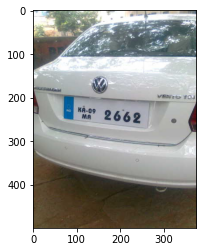

In [77]:
img= cv2.resize(cv2.imread("/content/drive/MyDrive/NumberPlates/Images/Cars154.png")/255.0, dsize=(WIDTH, HEIGHT))
y_hat = new_model.predict(img.reshape(1,WIDTH,HEIGHT,3)).reshape(-1)
    
xmi, ymi = int(y_hat[0]),int(y_hat[1])
xma, yma = int(y_hat[2]),int(y_hat[3])
img_=cv2.imread('/content/drive/MyDrive/NumberPlates/Images/Cars154.png')
plt.imshow(cv2.cvtColor(img_,cv2.COLOR_BGR2RGB))
y_hat

79 265 196 259


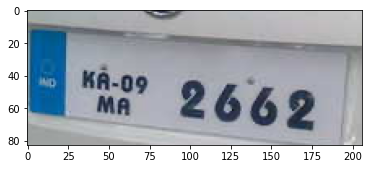

In [78]:
cropped_img=img_[ymi-10:yma+10,xmi-10:xma+10]
plt.imshow(cv2.cvtColor(cropped_img,cv2.COLOR_BGR2RGB))
print(xmi,xma,ymi,yma)

# Character Extraction

In [9]:
!pip install easyocr

     |████████████████████████████████| 63.6 MB 23 kB/s 
     |████████████████████████████████| 47.6 MB 36 kB/s 


In [82]:
import easyocr
reader=easyocr.Reader(['en'])

In [83]:
output=reader.readtext(cropped_img)
output

[([[28, 32], [79, 32], [79, 56], [28, 56]], 'Ka-09', 0.9643019667040862),
 ([[41, 51], [67, 51], [67, 67], [41, 67]], 'Ma', 0.9554086042591766),
 ([[86, 34], [185, 34], [185, 82], [86, 82]], '2662', 0.9999136924743652)]

In [84]:
text=""
for i in range(len(output)):
  text=text+output[i][-2]+" "

print("license Number of vehicle:",text)

license Number of vehicle: Ka-09 Ma 2662 


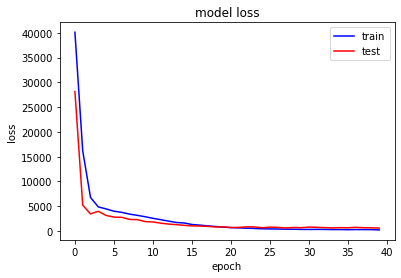

In [85]:
# Plot the loss curves for training and validation 
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="validation loss")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper right')